## ICESat-2 SlideRule Download

This code is adapted from Sliderule Python example code. It is designed to calculate ATL06 elevations from ATL03 points and save those elevations as a CSV. 

Activate the sliderule_env enviroment to run

<!-- Last updated by Karina Zikan July 2023 -->

In [1]:
import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [2]:
import sys
import time
import pyproj
import logging
import pandas as pd
import geopandas as gpd
import concurrent.futures
from datetime import datetime
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5

## SlideRule Configuration

In [3]:
# Configure ICESat-2 API
# pip show sliderule
icesat2.init("slideruleearth.io", verbose=False)
# icesat2.init("slideruleearth.io", verbose=False, loglevel=logging.INFO)

## Specify Region of Interest

#### 1. Make geojson from shapefile - if you have a geojson of the region skip to 2.

In [4]:
# Specify region of interest shapefile
shp = "/bsuhome/tnde/geoscience/carbon_estimation/shapefiles/RCEW-outline_WGS84.shp"
shapefile = gpd.read_file(shp)
# shapefile.to_file('/bsuhome/tnde/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.geojson', driver='GeoJSON')
shapefile.crs is None

ERROR 1: PROJ: proj_create_from_database: Open of /bsuhome/tnde/miniconda3/envs/lidar/share/proj failed


False

##### - Check shapefile crs

In [5]:
## if shapefile.crs is None is false check the crs
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

##### - Make Geojson

#### 2. Read in geojson for Region of Interest

In [6]:
# Specify region of interest from geojson
poly_fn = '/bsuhome/tnde/geoscience/carbon_estimation/shapefiles/RCEW-outline_WGS84.geojson'
raster = sliderule.toregion(poly_fn)["raster"] # geojson describing region of interest, enables use of rasterized region for subsetting
region = sliderule.toregion(poly_fn)["poly"] # symplify 
region
# poly_fn

[{'lon': -116.799, 'lat': 43.06089},
 {'lon': -116.7954, 'lat': 43.06089},
 {'lon': -116.7481, 'lat': 43.06268},
 {'lon': -116.747, 'lat': 43.06295},
 {'lon': -116.7411, 'lat': 43.06456},
 {'lon': -116.7409, 'lat': 43.06469},
 {'lon': -116.7392, 'lat': 43.06591},
 {'lon': -116.7379, 'lat': 43.06712},
 {'lon': -116.7179, 'lat': 43.09706},
 {'lon': -116.7008, 'lat': 43.12889},
 {'lon': -116.6963, 'lat': 43.13834},
 {'lon': -116.696, 'lat': 43.13915},
 {'lon': -116.6922, 'lat': 43.15454},
 {'lon': -116.6881, 'lat': 43.22341},
 {'lon': -116.6881, 'lat': 43.22476},
 {'lon': -116.6947, 'lat': 43.24693},
 {'lon': -116.6954, 'lat': 43.24828},
 {'lon': -116.6958, 'lat': 43.24883},
 {'lon': -116.702, 'lat': 43.2564},
 {'lon': -116.7022, 'lat': 43.25654},
 {'lon': -116.7579, 'lat': 43.2872},
 {'lon': -116.7605, 'lat': 43.28828},
 {'lon': -116.7612, 'lat': 43.28856},
 {'lon': -116.8199, 'lat': 43.31163},
 {'lon': -116.8251, 'lat': 43.31298},
 {'lon': -116.8266, 'lat': 43.31218},
 {'lon': -116.8303

In [7]:
# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]

<Figure size 800x1200 with 0 Axes>

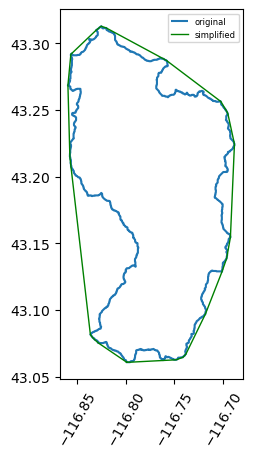

In [8]:
# Read geojson with geopandas
plt.figure(figsize=(8,12))
pregion = gpd.read_file(poly_fn)
map = pregion.plot(label = "original"); # plot origonal boundery 
map.plot(region_lon, region_lat, linewidth=1, color='g', label = "simplified"); # plot symplified region boundary for a sanity check
plt.legend(fontsize=6, loc="upper right")
plt.xticks(rotation=60)
plt.show()

#### 3. Save simplified polygon

In [9]:
polygon_geom = Polygon(zip(region_lon, region_lat))
# crs = 'epsg:4979'
polygon = gpd.GeoDataFrame(index=[0], geometry=[polygon_geom])       

polygon

,geometry
0,"POLYGON ((-116.799 43.06089, -116.7954 43.0608..."


### Save to file if you haven't already

In [10]:
# polygon.to_file('/bsuhome/tnde/geoscience/carbon_estimation/shapefiles/RCEW-outline_WGS84_simple.geojson', driver='GeoJSON')

# Sliderule Product processing

Follow the processing section for the desired product

### - ATL08 and ATL08_classified processing 

Choose ATL08 or ATL08_clssified parameters depending on what product you are downloading

#### ATL08 Parameters
We will use these parameters to retrieve ATL03 elevations with ATL08 classifications

#### Processing parameters
* 100m segments stepped every 100m
* Subsetted to the Grand Mesa region
* Time range is one day, Nov 14, 2019
* Only processing ground, canopy, and top of canopy photons
* Request the "h_dif_ref" variable as an ancillary field to be included in the results
* Running PhoREAL algorithm using a binsize of 1m, and geolocating each segment at the center of the segment
* Sending reconstructed waveforms along with metrics (for diagnostics and demonstration purposes only)


#### PhoREAL parameters
The PhoREAL vegetation algorithm, developed at the University of Texas at Austin, provides vegatation statistics over custom-length ATL03 photon segments. A subset of these algorithms have been integrated into SlideRule are accessed via the _atl08_ and _atl08p_ APIs using the `"phoreal"` parameter set.

To enable PhoREAL functionality, the "phoreal" parameter must be populated in the request dictionary.

- `"phoreal"`: dictionary of rasters to sample
- `"binsize"`: size of the vertical photon bin in meters
- `"geoloc"`: algorithm to use to calculate the geolocation (latitude, longitude, along-track distance, and time) of each custom length PhoREAL segment; “mean” - takes the average value across all photons in the segment; “median” - takes the median value across all photons in the segment; “center” - takes the halfway value calculated by the average of the first and last photon in the segment.
- `"use_abs_h"`: boolean whether the absolute photon heights are used instead of the normalized heights
- `"send_waveform"`: boolean whether to send to the client the photon height histograms in addition to the vegetation statistics
- `"above_classifier"`: boolean whether to use the ABoVE photon classifier when determining top of canopy photons

In [11]:
parms = { #Reynolds Creek Experimental Watershed
    "poly": region, # polygon defining region of interest 
    # "raster": raster, # geojson describing region of interest which enables rasterized subsetting on servers
    # "t0": '2018-11-26T00:00:00Z', # start time for filtering granules (format %Y-%m-%dT%H:%M:%SZ, e.g. 2018-10-13T00:00:00Z)
    # "t1": '2018-11-27T00:00:00Z', # stop time for filtering granuels (format %Y-%m-%dT%H:%M:%SZ, e.g. 2018-10-13T00:00:00Z)
    "srt": icesat2.SRT_LAND, # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "len": 100, # length of each extent in meters. If res is less than len, subsequent segments will contain duplicate photons.
    "res": 100, # step distance for successive extents in meters. Specifies the distance between subsequent extent centers.
    "dist_in_seg": False, # true|false flag indicating that the units of the "len" and "res" are in ATL03 segments (e.g. if true then a len=2 is exactly 2 ATL03 segments which is approximately 40 meters)
    "pass_invalid": True, # true|false flag indicating whether or not extents that fail validation checks are still used and returned in the results
    "atl03_ph_fields": ["pce_mframe_cnt"], # fields in the “heights” group of the ATL03 granule
    "atl03_geo_fields": ["solar_elevation"], # fields in the “geolocation” and “geophys_corr” groups of the ATL03 granule
    "atl08_class": ["atl08_ground", "atl08_canopy", "atl08_top_of_canopy"], # ATL08 photon classifications. The classifications are: “atl08_noise”, “atl08_ground”, “atl08_canopy”, “atl08_top_of_canopy”, “atl08_unclassified”)
    "atl08_fields": ["h_dif_ref"], # fields in the “land_segments” group of the ATL08 granule
    "phoreal": {"binsize": 1.0, "geoloc": "mean", "use_abs_h": False, "send_waveform": True} # "center", "mean", "median"
}

#### Calculate Elevations

In [12]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL08 Data
data = icesat2.atl08p(parm=parms, keep_id=True)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
#print("Reference Ground Tracks: {}".format(atl08_sr["rgt"].unique()))
#print("Cycles: {}".format(atl08_sr["cycle"].unique()))
print("Received {} elevations".format(data.shape[0]))

Completed in 39.288 seconds of wall-clock time
Received 68883 elevations


In [13]:
print(data.crs)
data.crs

EPSG:7912


<Geographic 3D CRS: EPSG:7912>
Name: ITRF2014
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: International Terrestrial Reference Frame 2014
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
data["h_mean_canopy"].describe()

count    59074.000000
mean         3.524071
std          6.554074
min          0.500610
25%          1.327734
50%          2.036808
75%          3.410110
max        145.840698
Name: h_mean_canopy, dtype: float64

## Plot ATL08 Results 

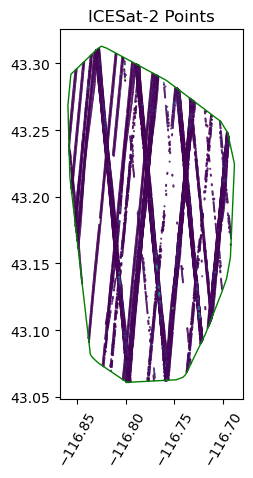

In [15]:
f, ax = plt.subplots()
ax.set_title("ICESat-2 Points")
ax.set_aspect('equal')
# data.plot(ax=ax, column='h_mean_canopy', cmap='Reds', s=0.1)
data.plot(ax=ax, column='h_mean_canopy', s=0.2)
ax.plot(region_lon, region_lat, linewidth=1, color='g');
# plt.legend(fontsize=6, loc="upper right")
plt.xticks(rotation=60)
plt.show()

## Projected Coordinate Reference System

### Horizontal Projection

In [16]:
# type(data)
data.columns

Index(['x_atc', 'h_min_canopy', 'h_te_median', 'gt', 'spot', 'rgt',
       'gnd_ph_count', 'h_mean_canopy', 'h_canopy', 'h_max_canopy',
       'snowcover', 'ph_count', 'canopy_h_metrics', 'solar_elevation_x',
       'segment_id', 'veg_ph_count', 'landcover', 'extent_id',
       'canopy_openness', 'cycle', 'geometry', 'num_bins', 'binsize',
       'waveform', 'pce_mframe_cnt', 'solar_elevation_y', 'h_dif_ref'],
      dtype='object')

In [17]:
# The EPSG code for NAD83/UTM zone 11N is 26911 (horizontal transformation) or 6340 for compound CRS. 
# utm_code = "epsg:26911"  # projected CRS for easier distance calculation
utm_code = "epsg:6340"  # Compound CRS represent both horizontal (UTM Zone 11N) and vertical (NAVD88) coordinate systems together. projected CRS for easier distance calculation.

data["Longitude"] = data["geometry"].x
data["Latitude"] = data["geometry"].y
data = data.to_crs(utm_code)
data["Easting"] = data["geometry"].x
data["Northing"] = data["geometry"].y
# eastnorths = data["geometry"].to_crs(utm_code)
# data["Easting"] = eastnorths.x
# data["Northing"] = eastnorths.y
print(len(data))
data.head()

68883


,x_atc,h_min_canopy,h_te_median,gt,spot,rgt,gnd_ph_count,h_mean_canopy,h_canopy,h_max_canopy,...,num_bins,binsize,waveform,pce_mframe_cnt,solar_elevation_y,h_dif_ref,Longitude,Latitude,Easting,Northing
time,,,,,,,,,,,,,,,,,,,,,
2018-11-26 21:09:05.589941504,4804119.0,5.104004,0.000000,10,6,905,0,5.501058,5.941040,5.941040,...,1,1.0,[1.0],277331720,22.217695,-3.892578,-116.691793,43.163764,525055.865662,4.779046e+06
2018-11-26 21:09:05.601814272,4804203.5,1.882690,1564.271729,10,6,905,1,13.568094,48.431396,48.431396,...,47,1.0,"[0.02777777798473835, 0.02777777798473835, 0.0...",277331721,22.216734,-3.892578,-116.691892,43.164521,525047.552739,4.779130e+06
2018-11-26 21:09:05.668974848,4804681.0,0.000000,1415.212646,10,6,905,1,NaN,0.000000,0.000000,...,1,1.0,[0.0],277331724,22.213209,-3.892578,-116.692458,43.168798,524999.764979,4.779605e+06
2018-11-26 21:09:05.730274816,4805116.5,0.000000,1354.815308,10,6,905,1,NaN,0.000000,0.000000,...,1,1.0,[0.0],277331727,22.209679,-3.892578,-116.692964,43.172700,524957.064863,4.780038e+06
2018-11-26 21:09:05.739774976,4805183.5,5.589478,0.000000,10,6,905,0,22.436945,45.274536,45.274536,...,40,1.0,"[0.04545454680919647, 0.0, 0.0, 0.0, 0.0454545...",277331727,22.209208,0.000000,-116.693045,43.173304,524950.212004,4.780105e+06


In [18]:
# # Check the number of missing values (NaNs) in the 'h_mean_canopy' column
missing_values = data["h_mean_canopy"].isna().sum()  
print(f"Missing values before: {missing_values}")
print(f'Number of zeros: {len(data[data["h_canopy"] == 0])}')

Missing values before: 9809
Number of zeros: 9809


### Vertical Projection

In [19]:
# Method 1: NAVD88 (vertical transformation) 
# Path to the geoid grid file for NAVD88
grid_path = pyproj.datadir.get_data_dir() + "/us_noaa_g2018u0.tif" # best available transformation for CONUS (United States mainland) uses us_noaa_g2018u0.tif
# grid_path = pyproj.datadir.get_data_dir() + "/us_noaa_vertconw.tif"

# Define PROJ pipeline using GEOID12B (us_noaa_g2012ba0.tif)
proj_pipeline = f"""
    +proj=pipeline 
    +step +proj=vgridshift +grids={grid_path}
"""

# Create the transformer for vertical transformation only using the PROJ pipeline. The transformer uses the geoid model
vertical_transformer1 = pyproj.Transformer.from_pipeline(proj_pipeline)

# # Apply vertical transformation (only changing elevation)
data["elevation_NAVD88_icesat2_from_pipe"] = data.apply(
    lambda row: vertical_transformer1.transform(row.Longitude, row.Latitude, row.h_te_median)[-1],
    axis=1
)

##########################
# Method 2: NAVD88 (vertical transformation) 
# Explicitly define source and target CRS
source_crs = "EPSG:7912" # Source CRS: WGS84 with ellipsoidal height (3D)
target_crs = "EPSG:6340+5703" # Target CRS: UTM Zone 11N (horizontal) + NAVD88 (vertical) gravity-related height

# Create the transformation with explicit CRS definition
vertical_transformer2 = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Apply the transformation (longitude, latitude remain unchanged)
_, __, data["elevation_NAVD88_icesat2_from_crs"] = zip(
    *data.apply(lambda row: vertical_transformer2.transform(row.Longitude, row.Latitude, row.h_te_median), axis=1)
)

data.head()
display(data[["h_te_median", "elevation_NAVD88_icesat2_from_pipe", "elevation_NAVD88_icesat2_from_crs"]].head())

,h_te_median,elevation_NAVD88_icesat2_from_pipe,elevation_NAVD88_icesat2_from_crs
time,,,
2018-11-26 21:09:05.589941504,0.000000,16.780500,17.329683
2018-11-26 21:09:05.601814272,1564.271729,1581.055030,1581.604194
2018-11-26 21:09:05.668974848,1415.212646,1432.010362,1432.559422
2018-11-26 21:09:05.730274816,1354.815308,1371.624797,1372.173761
2018-11-26 21:09:05.739774976,0.000000,16.811302,17.360251


In [20]:
data.columns

Index(['x_atc', 'h_min_canopy', 'h_te_median', 'gt', 'spot', 'rgt',
       'gnd_ph_count', 'h_mean_canopy', 'h_canopy', 'h_max_canopy',
       'snowcover', 'ph_count', 'canopy_h_metrics', 'solar_elevation_x',
       'segment_id', 'veg_ph_count', 'landcover', 'extent_id',
       'canopy_openness', 'cycle', 'geometry', 'num_bins', 'binsize',
       'waveform', 'pce_mframe_cnt', 'solar_elevation_y', 'h_dif_ref',
       'Longitude', 'Latitude', 'Easting', 'Northing',
       'elevation_NAVD88_icesat2_from_pipe',
       'elevation_NAVD88_icesat2_from_crs'],
      dtype='object')

## Write to csv - ATL08

In [26]:
data["Date"] = pd.to_datetime(data.index)
data["date"] = pd.to_datetime(data["Date"])
data_new = data.copy()
data_new = data[(data["date"].dt.month >= 5)&(data["date"].dt.month <= 10)]
print(len(data_new))

34863


In [27]:
print(data_new["h_mean_canopy"].describe())

# Check the number of missing values (NaNs) in the 'h_mean_canopy' column
missing_values = data_new["h_mean_canopy"].isna().sum()
print(f"Missing values before: {missing_values}")

# Replace NaN values with 0 in the 'h_mean_canopy' column
data_new["h_mean_canopy"].fillna(0, inplace=True)

# Check the number of missing values again after replacement
missing_values_after = data_new["h_mean_canopy"].isna().sum()
print(f"Missing values after: {missing_values_after}")

data_new["h_mean_canopy"].describe()

count    28604.000000
mean         3.888473
std          6.083481
min          0.502075
25%          1.453629
50%          2.266972
75%          3.969375
max        131.431427
Name: h_mean_canopy, dtype: float64
Missing values before: 6259
Missing values after: 0


count    34863.000000
mean         3.190370
std          5.708905
min          0.000000
25%          0.921664
50%          1.870357
75%          3.404550
max        131.431427
Name: h_mean_canopy, dtype: float64

In [28]:
cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/rcew_icesat2_atl08_all_new_final.csv" #set name of the output #set name of the output
data_new.to_csv(cvs_name)

## Write to geojson

In [29]:
outName = cvs_name.replace(".csv", ".geojson")  # Create an output file name using the input file name
outName

'/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/rcew_icesat2_atl08_all_new_final.geojson'

In [30]:
data_new.to_file(outName, driver="GeoJSON")  # Export to GeoJSON